In [1]:
import pandas as pd
import numpy as np  
import re
from nltk.corpus import stopwords
from numpy import array 


from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Dense
from sklearn.model_selection import train_test_split

2024-08-15 14:27:35.253949: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 14:27:35.433699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-15 14:27:35.607464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 14:27:35.770800: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 14:27:35.809593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 14:27:36.099572: I tensorflow/core/platform/cpu_feature_gu

In [5]:
news = pd.read_csv("Airline-Sentiment-2-w-AA.csv", encoding="ISO-8859-1")
news.shape

(14640, 20)

In [6]:
news.head(5)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


<Axes: xlabel='airline_sentiment', ylabel='count'>

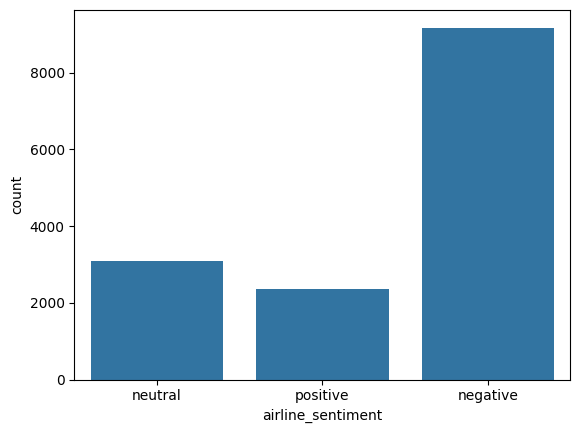

In [7]:
import seaborn as sns
sns.countplot(x='airline_sentiment', data=news)

In [8]:
news["text"][0]

'@VirginAmerica What @dhepburn said.'

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [13]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(news["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [14]:
X[0]

' virginamerica dhepburn said '

In [28]:
# Converting sentiment labels to 0 to netutral, -1 negative, 1 positive

y = news['airline_sentiment']

y = np.array(list(map(lambda x: -1 if x== "negative" else 1 if x == "positive" else 0, y)))

print(y[0], y[1], y[3])

0 1 -1


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.8, random_state=23)

In [30]:
# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [31]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

11914

In [32]:

X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

In [33]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [34]:
# Create Embedding Matrix having 100 columns 
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [35]:
embedding_matrix.shape

(11914, 100)

## Recurrent Neural Network (LSTM)

In [36]:
from keras.layers import Conv1D

In [37]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [38]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,191,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,191,400 (4.54 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,191,400 (4.54 MB)

None


In [43]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=8, verbose=1, validation_split=0.2)

Epoch 1/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2137 - loss: -5348.5225 - val_acc: 0.2215 - val_loss: -5849.6895
Epoch 2/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2164 - loss: -6412.8530 - val_acc: 0.2215 - val_loss: -6958.5884
Epoch 3/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.2155 - loss: -7622.4932 - val_acc: 0.2215 - val_loss: -8163.0737
Epoch 4/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2079 - loss: -9134.3975 - val_acc: 0.2215 - val_loss: -9437.6514
Epoch 5/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2065 - loss: -10282.0596 - val_acc: 0.2215 - val_loss: -10797.0879
Epoch 6/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2092 - loss: -11887.1045 - val_acc: 0.2215 - val_loss: -12242.0146
Epoch 7/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2144 - loss: -13257.8760 - val_acc: 0.2215 - val_loss: -13742.9326
Epoch 8/8
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.2110 - loss: -15009.7744 - val_acc: 0.2215 - val_loss: -15323.5459


In [40]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2076 - loss: -4799.1724


In [41]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: -4834.541015625
Test Accuracy: 0.20730873942375183


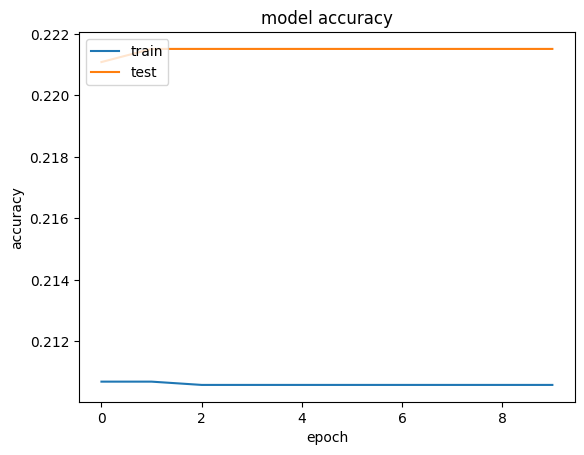

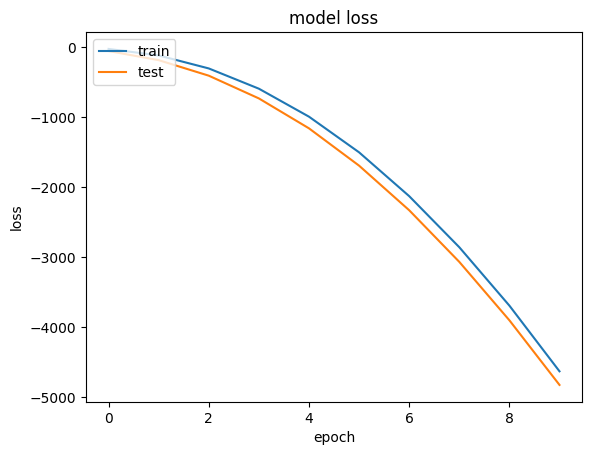

In [42]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()